## **COMP-3704 (241552) Neural Networks and Deep Learning**
## **Assignment 2 - Date Fruit Classification**
## **Group 3: Felix, Elizer, Francisco**

### **Objective:**

To determine the variety of date fruit from data describing the colour, length, diameter, and shape.

### **Question1. Data**
**Part a)**
* Load Date_Fruit_Datasets.csv into a pandas dataframe. Print out the header.\
* Use pandas.DataFrame.describe to summarize the data.\
* Using markdown, explain the meaning of the columns (as well as you can with the information available) and make observations about the dataset.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input

#supress warnings
import warnings
warnings.filterwarnings("ignore")

### Common functions

Functions used in different sections

In [72]:
# functions that will be used across the notebook

# generates and display metrics
def show_results(model, x_train, y_train, x_val, y_val, y_val_pred):

    train_result = model.test_on_batch(x_train, y_train)
    val_result = model.test_on_batch(x_val, y_val)

    report = classification_report(y_val, y_val_pred, output_dict=True)

    train_loss = train_result[0]
    train_acu = train_result[1]

    val_loss = val_result[0]
    val_acu = report["accuracy"]
    val_f_score = report["weighted avg"]["f1-score"]

    data = {'train': [train_loss, train_acu, '--'],
        'validate': [val_loss, val_acu, val_f_score]
        }

    df = pd.DataFrame(data, index=['loss', 'accuracy', 'f1-score'])
    display(df)

    return { "loss": val_loss, "accuracy": val_acu, "fscore": val_f_score }

# display metrics for testing case
def show_results_test(model, x_test, y_test, y_test_pred):

    test_result = model.test_on_batch(x_test, y_test)
    report = classification_report(y_test, y_test_pred, output_dict=True)

    test_loss = test_result[0]
    test_acu = report["accuracy"]
    test_f_score = report["weighted avg"]["f1-score"]

    data = { 'testing': [test_loss, test_acu, test_f_score] }

    df = pd.DataFrame(data, index=['loss', 'accuracy', 'f1-score'])
    display(df)

# display confusion matrix along with the labels
def show_confusion_matrix(title, labels, y, y_predicted):
    cm = confusion_matrix(y, y_predicted)

    cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)

    fig, ax = plt.subplots(figsize=(3,3))
    plt.grid(False)
    plt.title(title)

    cmd.plot(ax=ax, colorbar=False, cmap=plt.cm.Blues, xticks_rotation="vertical")

def predict_y(model, x):

    y_predicted = model.predict(x, verbose = 0)
    y_pred = np.argmax(y_predicted, axis=1)

    return y_pred

# display the metrics and confusion matrix of a model
def show_model(model, name, X_train, y_train, X_val, y_val, labels_ordered, show_summary = False):

    print("model: " + name)

    if show_summary:
        model.summary()

    y_val_predictions = predict_y(model, X_val)

    result = show_results(model, X_train, y_train, X_val, y_val, y_val_predictions)
    show_confusion_matrix("Validation matrix", labels_ordered, y_val, y_val_predictions)

    return result

### **Question 1. Data**
**Part a)**
* Load Date_Fruit_Datasets.csv into a pandas dataframe.
* Print out the header.\
* Use pandas.DataFrame.describe to summarize the data.\
* Using markdown, explain the meaning of the columns (as well as you can with the information available) and make observations about the dataset.

In [3]:
# Import database using github link
url = "https://raw.githubusercontent.com/Fcazarez/NeuralNetworks/main/Date_Fruit_Datasets.csv"
df = pd.read_csv(url, error_bad_lines=False)

# take a look at the data
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-5.919126e+10,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-3.423307e+10,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-9.394835e+10,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-3.207431e+10,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-3.998097e+10,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


In [4]:
# random five data rows
# divide the table by columns for better display
five_rows = df.sample(5)
display(five_rows.iloc[:, :16])
display(five_rows.iloc[:, 16:])

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4
166,208042,1725.8110,649.4158,411.8994,0.7731,514.6721,0.9918,209753,0.7331,1.5766,0.8778,0.7925,0.0031,0.0020,0.6281,0.9903
717,342828,2287.8721,844.0139,520.2556,0.7874,660.6831,0.9639,355683,0.6706,1.6223,0.8230,0.7828,0.0025,0.0015,0.6128,0.9941
401,408254,2345.2939,803.2890,647.9013,0.5912,720.9752,0.9940,410709,0.7786,1.2398,0.9327,0.8975,0.0020,0.0016,0.8056,0.9988
543,412688,2640.7351,924.9248,576.3412,0.7821,724.8798,0.9723,424464,0.7013,1.6048,0.7437,0.7837,0.0022,0.0014,0.6142,0.9857
347,77054,1010.3730,358.0397,274.4490,0.6422,313.2223,0.9930,77599,0.8018,1.3046,0.9485,0.8748,0.0046,0.0036,0.7653,0.9984


,MeanRR,MeanRG,MeanRB,StdDevRR,StdDevRG,StdDevRB,SkewRR,SkewRG,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
166,104.7724,93.1733,87.2115,34.2646,31.6825,27.3743,0.0072,0.2815,0.3013,2.2060,2.2021,2.7079,-2.424186e+10,-18904291328,-16004977664,52.3850,46.5880,43.6055,DOKOL
717,46.9433,52.6326,64.2881,22.2749,21.7307,20.8924,1.9778,2.1572,0.6541,10.1256,10.5755,4.3526,-7.703044e+09,-9362766848,-13504945152,23.4737,26.3182,32.1465,SAFAVI
401,80.5484,90.3750,93.4249,26.8211,24.8394,28.9532,0.5345,1.1532,0.9322,4.9121,6.5846,5.1196,-2.672346e+10,-33098913792,-36510957568,40.2738,45.1886,46.7127,IRAQI
543,122.5234,115.3404,117.9508,39.3104,39.9843,40.2534,0.0129,0.1528,0.1702,2.0023,2.0234,2.2319,-6.760202e+10,-60375031808,-63160799232,61.2619,57.6712,58.9758,ROTANA
347,130.3774,124.8933,111.0892,32.5603,22.8696,29.7671,-1.2085,-0.5998,-0.1346,3.8163,3.2550,2.2688,-1.377832e+10,-12110615552,-9802575872,65.1898,62.4501,55.5499,DOKOL


In [5]:
# Some stats about each column
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AREA,898.0,2.982952e+05,1.072452e+05,1.987000e+03,2.069480e+05,3.198330e+05,3.825730e+05,5.460630e+05
PERIMETER,898.0,2.057661e+03,4.100125e+02,9.118280e+02,1.726091e+03,2.196345e+03,2.389717e+03,2.811997e+03
MAJOR_AXIS,898.0,7.508120e+02,1.440593e+02,3.367227e+02,6.410686e+02,7.913634e+02,8.586338e+02,1.222723e+03
MINOR_AXIS,898.0,4.958728e+02,1.142689e+02,2.283200e+00,4.046844e+02,4.950548e+02,5.890317e+02,7.664536e+02
ECCENTRICITY,898.0,7.374678e-01,8.872739e-02,3.448000e-01,6.856250e-01,7.547000e-01,8.021500e-01,1.000000e+00
EQDIASQ,898.0,6.045779e+02,1.195939e+02,5.029840e+01,5.133171e+02,6.381409e+02,6.979305e+02,8.338279e+02
SOLIDITY,898.0,9.818403e-01,1.815742e-02,8.366000e-01,9.788250e-01,9.873000e-01,9.918000e-01,9.974000e-01
CONVEX_AREA,898.0,3.038456e+05,1.088157e+05,2.257000e+03,2.100228e+05,3.272070e+05,3.888040e+05,5.525980e+05
EXTENT,898.0,7.362671e-01,5.374518e-02,5.123000e-01,7.058750e-01,7.469500e-01,7.758500e-01,8.562000e-01
ASPECT_RATIO,898.0,2.131102e+00,1.782078e+01,1.065300e+00,1.373725e+00,1.524150e+00,1.674750e+00,5.355257e+02


| Feature         | Description                                                 |
|-----------------|-------------------------------------------------------------|
| AREA            | The area of the date fruit region in the image.            |
| PERIMETER       | The perimeter (boundary length) of the date fruit region.  |
| MAJOR_AXIS      | The length of the major axis (longest diameter) of the date fruit. |
| MINOR_AXIS      | The length of the minor axis (shortest diameter) of the date fruit. |
| ECCENTRICITY    | A measure of how elongated or stretched the date fruit shape is. |
| EQDIASQ         | Equivalent diameter, a measure of the diameter of a circle with the same area as the date fruit. |
| SOLIDITY        | The ratio of the area of the date fruit region to its convex hull. |
| CONVEX_AREA     | The area of the convex hull of the date fruit.             |
| EXTENT          | A measure of how spread out the date fruit region is within its bounding box. |
| ASPECT_RATIO    | The ratio of the major axis length to the minor axis length. |
| ROUNDNESS       | A measure of how closely the date fruit resembles a perfect circle. |
| COMPACTNESS     | A measure of how compact the date fruit region is.         |
| SHAPEFACTOR_1 to SHAPEFACTOR_4 | Various shape factors describing the date fruit's geometry. |
| MeanRR, MeanRG, MeanRB | Mean values of color channels (Red, Green, Blue) in the date fruit region. |
| StdDevRR, StdDevRG, StdDevRB | Standard deviations of color channels in the date fruit region. |
| SkewRR, SkewRG, SkewRB | Skewness of color channels in the date fruit region.       |
| KurtosisRR, KurtosisRG, KurtosisRB | Kurtosis of color channels in the date fruit region. |
| EntropyRR, EntropyRG, EntropyRB | Entropy (information content) of color channels in the date fruit region. |
| ALLdaub4RR, ALLdaub4RG, ALLdaub4RB | Features related to color transformation. |
| Class           | The target variable representing the class or category of the date fruit. |


In [6]:
# if there are any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float64
 17  MeanRG         898 non-null    float64
 18  MeanRB    

We have 898 rows with 35 features and no missing values

In [7]:
#Column Description
print(f"We've got {len(df.columns)} columns")
print('Columns are: \n', df.columns)

We've got 35 columns
Columns are: 
 Index(['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY',
       'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2',
       'SHAPEFACTOR_3', 'SHAPEFACTOR_4', 'MeanRR', 'MeanRG', 'MeanRB',
       'StdDevRR', 'StdDevRG', 'StdDevRB', 'SkewRR', 'SkewRG', 'SkewRB',
       'KurtosisRR', 'KurtosisRG', 'KurtosisRB', 'EntropyRR', 'EntropyRG',
       'EntropyRB', 'ALLdaub4RR', 'ALLdaub4RG', 'ALLdaub4RB', 'Class'],
      dtype='object')


In [8]:
## Identify the classes classes
df["Class"].unique()

array(['BERHI', 'DEGLET', 'DOKOL', 'IRAQI', 'ROTANA', 'SAFAVI', 'SOGAY'],
      dtype=object)

In [9]:
X = df.drop("Class", axis=1) #feature dataset
y = df.loc[:, "Class"] #label dataset

**Features Scaling**
Scale all of the values between the 0 and 1 range. This is called normalization and can be done with scikit-learn's MinMaxScaler class.


In [10]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

X = pd.DataFrame(x_scaled)

X.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.772274,0.772079,0.565604,0.841941,0.446429,0.871512,0.983209,0.767108,0.787438,0.000435,...,0.395739,0.062495,0.053715,0.080752,0.458251,0.455197,0.546327,0.673513,0.550537,0.494665
1,0.617835,0.617480,0.436904,0.775906,0.342186,0.773229,1.000000,0.611906,0.776970,0.000282,...,0.350002,0.037387,0.040885,0.046033,0.687311,0.599151,0.643352,0.538923,0.516341,0.494501
2,0.964674,0.913374,0.681733,0.933143,0.464896,0.981104,0.992537,0.956896,0.736842,0.000467,...,0.472509,0.083531,0.089677,0.096843,0.139260,0.194220,0.312066,0.777967,0.619782,0.573507
3,0.761063,0.757502,0.554467,0.841456,0.430098,0.864727,0.983831,0.755891,0.766502,0.000408,...,0.687121,0.136202,0.278800,0.213061,0.707124,0.657830,0.665214,0.436260,0.377376,0.366683
4,0.635159,0.657060,0.482240,0.759716,0.460470,0.784821,0.958955,0.633316,0.711253,0.000459,...,0.464794,0.040608,0.054459,0.086850,0.634558,0.615256,0.710963,0.581443,0.485820,0.395128


### **Question 1. Data**
**Part b)**
* Use pandas.DataFrame.info to check if the entries are the correct datatype, and if there are any missing values.\
* Use pandas.DataFrame.duplicates to check for duplicate entries.\
* Fix the dataset so that there are no missing values, duplicate rows, or incorrect data types.\
* Use markdown to make observations and explain what you have done.

In [11]:
# Check for duplicate rows
duplicateRows = df[df.duplicated()]
print(duplicateRows)

Empty DataFrame
Columns: [AREA, PERIMETER, MAJOR_AXIS, MINOR_AXIS, ECCENTRICITY, EQDIASQ, SOLIDITY, CONVEX_AREA, EXTENT, ASPECT_RATIO, ROUNDNESS, COMPACTNESS, SHAPEFACTOR_1, SHAPEFACTOR_2, SHAPEFACTOR_3, SHAPEFACTOR_4, MeanRR, MeanRG, MeanRB, StdDevRR, StdDevRG, StdDevRB, SkewRR, SkewRG, SkewRB, KurtosisRR, KurtosisRG, KurtosisRB, EntropyRR, EntropyRG, EntropyRB, ALLdaub4RR, ALLdaub4RG, ALLdaub4RB, Class]
Index: []

[0 rows x 35 columns]


In [12]:
# Drop rows with missing values
df.dropna(inplace=True)

In [13]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [14]:
# check if the datatype are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float64
 17  MeanRG         898 non-null    float64
 18  MeanRB    

**Comments & Observations:**

After running the info(), We double-checked that all types are correct and also checked for duplicate lines and drop_duplicated to make sure there is no duplicate data.Then I used dropna to remove the missing values

### **Question 1. Data**
 **Part c)**
* Create a bar plot using seaborn.barplot of the number of elements in each category.\
* Use markdown to comment on how well balanced the dataset is.

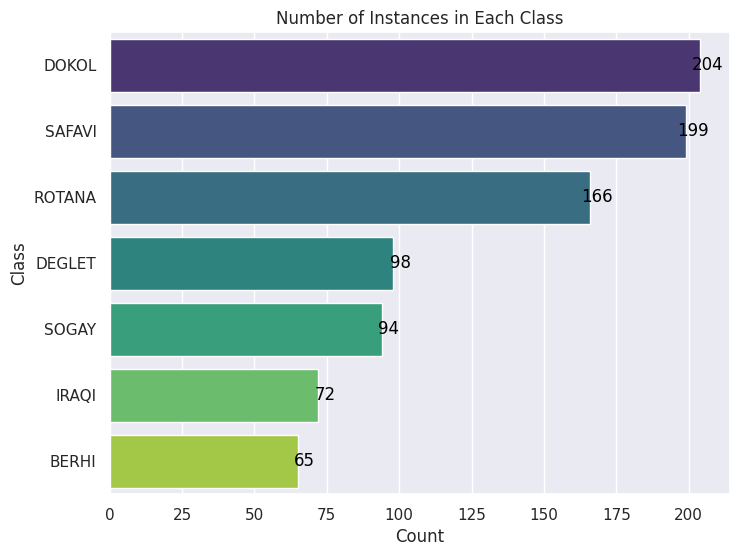

In [15]:
# Count the number of occurrences of each class
class_counts = df["Class"].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(y=class_counts.index, x=class_counts.values, orient="h", palette="viridis")
plt.title("Number of Instances in Each Class")
plt.xlabel("Count")
plt.ylabel("Class")

# Add the number inside each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='center', va='center', fontsize=12, color='black', xytext=(5, 0),
                textcoords='offset points')

plt.show()


### **Comments & Observations about the dataset:**
The dataset is not balanced because the classes DOKOL, SAFAVI AND ROTANA contains each around 20% of the total elements, while the DEGLET, SOGAY, IRAQUI and BERHI between 11% and 7% each.

### **Question 1. Data**
**Part d)**
* Move the labels into a separate dataframe and use sklearn.preprocessing.LabelEncoder to convert the string labels into integers.\
* Reshape the labels into a 2d array.\
* Determine which number has been assigned to each type of date and record this information in markdown.\


In [67]:
# lets check the order of the encoded labels, later this info will be used
# to improve matrix correlation display

labels = df["Class"]  # Extract the labels

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels to convert string labels to integers
encoded_labels = label_encoder.fit_transform(labels)

# Reshape the labels into a 2D array
encoded_labels_2d = encoded_labels.reshape(-1, 1)

# Determine the assigned numbers for each type of label
label_mapping = {label: number for label, number in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}

# Print the label mapping information in Markdown format
print("Label Mapping:")
for label, number in label_mapping.items():
    print(f"- {label}: {number}")


Label Mapping:
- BERHI: 0
- DEGLET: 1
- DOKOL: 2
- IRAQI: 3
- ROTANA: 4
- SAFAVI: 5
- SOGAY: 6


### **Question 1. Data**
**Part e)**

* Splitting the dataset into the Training set and Test set
Dataset 80% Training, 10% validation and 10% Testing

Dataset 80% Training, 10% validation and 10% Testing

In [17]:
X_train, X_temporary, y_train, y_temporary = train_test_split(X, encoded_labels_2d, train_size = 0.8)
X_val, X_test, y_val, y_test = train_test_split(X_temporary, y_temporary, train_size = 0.5)

In [18]:
print(f"Length of the Dataset:, {len(X)}")
print(f"Length of the Training Dataset:, {len(X_train)}")
print(f"Length of the Validation Dataset:, {len(X_val)}")
print(f"Length of the Test Dataset:, {len(X_test)}")

Length of the Dataset:, 898
Length of the Training Dataset:, 718
Length of the Validation Dataset:, 90
Length of the Test Dataset:, 90


### **Modeling**
**Part d)**
* Return to the above steps to try at least five different choices of hyperparameters (including dimensions, activation functions, number of layers, optimizer, loss function, etc.).
* Neatly present a description each model tried along with the training and validation accuracies, and the confusion matrix

In [19]:
# different hyperparams
# models will be executed sequentially 

# 6 different models will be executed, with variations of Nodes, layers, dropout and optimizers.
# SGD will be tested to check if it gets stuck in a local minima
# Adamax is a variant of adam that performs well in prescense of noise data
# Nodes go from 1000 to 8192 and layers from 2 to 6 the idea is to test if more complex models 
# can provide better results than simpler models like the first one in the list.

#first element correspond to the model required by default

hyper_params = [{"nodes": 4096, "layers": 2, 'epochs': 50, "dropout": 0.5, "out_activation":"softmax",
           "hidden_activation": "relu", "optimizer":'SGD', "loss":'sparse_categorical_crossentropy'},
                
          {"nodes": 4096, "layers": 4, 'epochs': 80, "dropout": 0.6, "out_activation":"softmax",
           "hidden_activation": "relu", "optimizer":'adam', "loss":'sparse_categorical_crossentropy'},

          {"nodes": 8192, "layers": 2, 'epochs': 75, "dropout": 0.5, "out_activation":"softmax",
           "hidden_activation": "relu", "optimizer":'adamax', "loss":'sparse_categorical_crossentropy'},

          {"nodes": 1000, "layers": 6, 'epochs': 80, "dropout": 0.25, "out_activation":"softmax",
           "hidden_activation": "relu", "optimizer":'nadam', "loss":'sparse_categorical_crossentropy'},

          {"nodes": 6305, "layers": 4, 'epochs': 50, "dropout": 0.5, "out_activation":"softmax",
           "hidden_activation": "relu", "optimizer":'adam', "loss":'sparse_categorical_crossentropy'},

          {"nodes": 5000, "layers": 6, 'epochs': 80, "dropout": 0.6, "out_activation":"softmax",
           "hidden_activation": "relu", "optimizer":'adam', "loss":'sparse_categorical_crossentropy'}

          ]


In [20]:
def create_model(nodes_quantity, hidden_activation, number_of_layers, dropout, out_activation):

    #Create a model object
    model = tf.keras.Sequential()

    #Create an Input Layer #we use Relu as activation function
    input_layer = tf.keras.layers.Dense(nodes_quantity, input_shape=(34,), activation=hidden_activation)

    #Add input layer to model object
    model.add(input_layer)

    for i in range(number_of_layers):

        model.add(tf.keras.layers.Dense(nodes_quantity , activation = hidden_activation))
        model.add(tf.keras.layers.Dropout(dropout))

    #Add output layer softmax activation function
    model.add(tf.keras.layers.Dense(7, activation = out_activation))

    return model

In [21]:
#lets create and train all the 5 models

all_models = []

for i in range(len(hyper_params)):

    _nodes = hyper_params[i]["nodes"]
    _hidden_activation = hyper_params[i]["hidden_activation"]
    _layers = hyper_params[i]["layers"]
    _dropout = hyper_params[i]["dropout"]
    _out_activation = hyper_params[i]["out_activation"]
    _optimizer = hyper_params[i]["optimizer"]
    _loss = hyper_params[i]["loss"]
    _epochs = hyper_params[i]["epochs"]

    model = create_model(_nodes, _hidden_activation, _layers, _dropout, _out_activation)
    model.compile(optimizer=_optimizer, loss=_loss, metrics=['accuracy'])

    ##Train the model for N  epochs

    results = model.fit(X_train, y_train, epochs=_epochs, batch_size=32, validation_data=(X_val, y_val))
    all_models.append({"model": model, "results": results})


Epoch 1/50
23/23 [==============================] - 3s 28ms/step - loss: 1.9078 - accuracy: 0.2479 - val_loss: 1.8647 - val_accuracy: 0.4111
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 1.8288 - accuracy: 0.4387 - val_loss: 1.8055 - val_accuracy: 0.4111
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 1.7808 - accuracy: 0.4513 - val_loss: 1.7548 - val_accuracy: 0.4111
Epoch 4/50
23/23 [==============================] - 0s 11ms/step - loss: 1.7347 - accuracy: 0.4805 - val_loss: 1.7057 - val_accuracy: 0.4444
Epoch 5/50
23/23 [==============================] - 0s 10ms/step - loss: 1.6903 - accuracy: 0.5097 - val_loss: 1.6555 - val_accuracy: 0.4444
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 1.6373 - accuracy: 0.5209 - val_loss: 1.5994 - val_accuracy: 0.4778
Epoch 7/50
23/23 [==============================] - 0s 11ms/step - loss: 1.5836 - accuracy: 0.5501 - val_loss: 1.5323 - val_accuracy: 0.5778
Epoch 8/50
23

### **Modeling**
**Part d)**
* Return to the above steps to try at least five different choices of hyperparameters (including dimensions, activation functions, number of layers, optimizer, loss function, etc.).
* Neatly present a description each model tried along with the training and validation accuracies, and the confusion matrix

### **MODELS**

* 6 models executed secuentially

In [51]:
# this array will hold the loss, accuracy and f-score calculated for each model
calculated_metrics = []

model: first
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              143360    
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 28679     
                                                                 
Total params: 33734663 (128.69 MB)
Trainabl

,train,validate
loss,0.480882,0.410226
accuracy,0.834262,0.888889
f1-score,--,0.880529


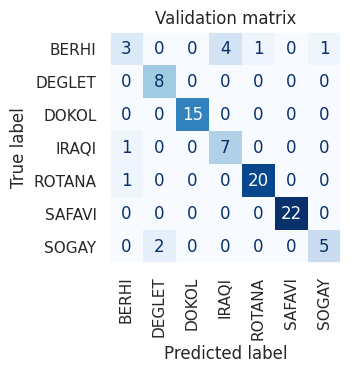

In [53]:
# Print a summary of the model using tf.summary.

first_model = all_models[0]["model"]
metrics = show_model(first_model, "first", X_train, y_train, X_val, y_val, label_mapping.keys(), True)
calculated_metrics.append(metrics)

model: second


,train,validate
loss,0.265274,0.178466
accuracy,0.9039,0.933333
f1-score,--,0.936816


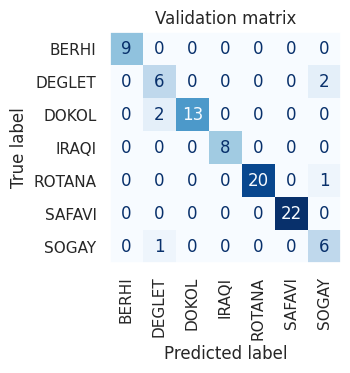

In [55]:
second_model = all_models[1]["model"]
metrics_2 = show_model(second_model,"second", X_train, y_train, X_val, y_val, label_mapping.keys())
calculated_metrics.append(metrics_2)

model: third


,train,validate
loss,0.186018,0.199119
accuracy,0.920613,0.911111
f1-score,--,0.913762


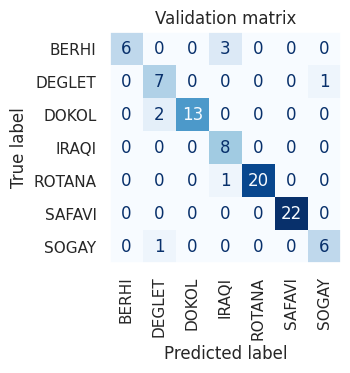

In [56]:
third_model = all_models[2]["model"]
metrics_3 = show_model(third_model,"third", X_train, y_train, X_val, y_val, label_mapping.keys())
calculated_metrics.append(metrics_3)

model: fourth


,train,validate
loss,0.117077,0.099725
accuracy,0.958217,0.944444
f1-score,--,0.947455


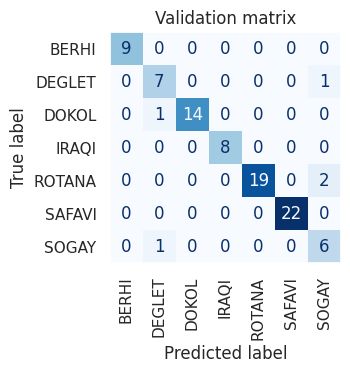

In [57]:
fourth_model = all_models[3]["model"]
metrics_4 = show_model(fourth_model,"fourth", X_train, y_train, X_val, y_val, label_mapping.keys())
calculated_metrics.append(metrics_4)

model: five


,train,validate
loss,0.258162,0.253192
accuracy,0.906685,0.888889
f1-score,--,0.886967


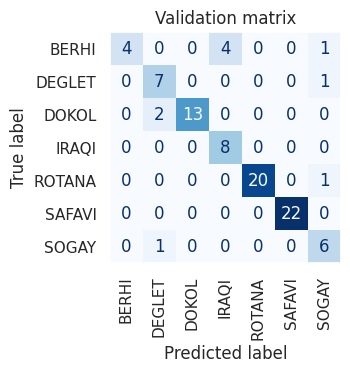

In [58]:
five_model = all_models[4]["model"]
metrics_5 = show_model(five_model,"five", X_train, y_train, X_val, y_val, label_mapping.keys())
calculated_metrics.append(metrics_5)

model: sixth


,train,validate
loss,0.500133,0.592618
accuracy,0.763231,0.744444
f1-score,--,0.753914


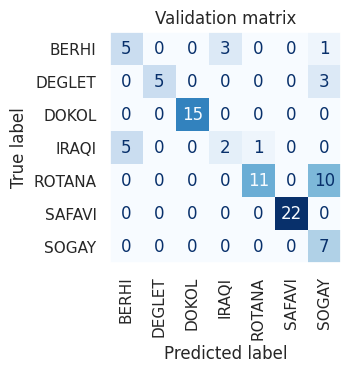

In [60]:
sixth_model = all_models[5]["model"]
metrics_6 = show_model(sixth_model,"sixth", X_train, y_train, X_val, y_val, label_mapping.keys())
calculated_metrics.append(metrics_6)

### **Conclusion**
**Part a)**
* Select the best model and justify your selection using markdown.

**Part b)**
* Use the best model to make predictions on the testing set. Find the testing accuracy and confusion matrix.

**Part c)**
* Use markdown to comment on how well the model works to make predictions for this use case.

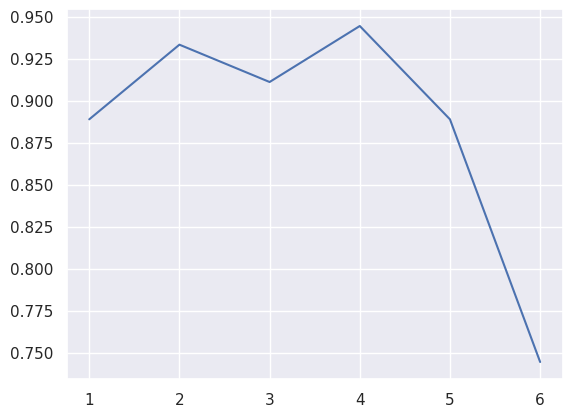

In [62]:
def myfunc(a):
   return a["accuracy"]

plt.plot(range(1,7), list(map(myfunc, calculated_metrics)))

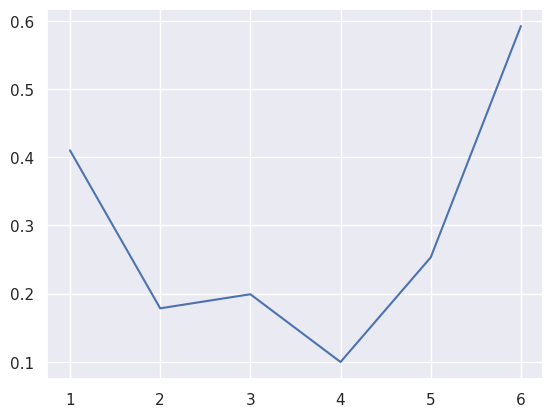

In [63]:
def myfunc(a):
   return a["loss"]

plt.plot(range(1,7), list(map(myfunc, calculated_metrics)))

### Best model

Best model will be selected taking into consideration highest accuracy and lowest loss

,testing
loss,0.397674
accuracy,0.955556
f1-score,0.956439


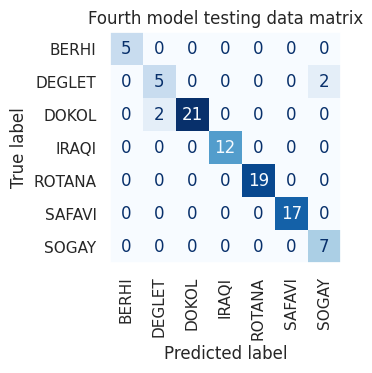

In [71]:
best_model = all_models[3]["model"]

y_test_predictions = predict_y(best_model, X_test)

show_results_test(model, X_test, y_test, y_test_predictions)

show_confusion_matrix("Fourth model testing data matrix", label_mapping.keys(), y_test, y_test_predictions)

We developed and evaluated Machine 6 learning models for the task of identifying date fruit varieties based on their external features. 
The best model, selected based on validation accuracy (0.94), demonstrated its ability to classify date fruits effectively. The main criteria to decide what is the best model is Acurracy, loss and f1 scor in that order of priority.

Overall, the best model exhibits good performance during the testing (0.95) phase. It achieves high accuracy, low loss, and a strong F1-score, demonstrating its ability to accurately classify date fruit varieties based on their selected features.

 The model could provide valuable insights for accurate date fruit variety identification, which can be beneficial for food labelling and quality control purposes.